In [11]:
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import Table
import sys

In [39]:
plt.style.use('~/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

In [9]:
specNN = '/n/home03/vchandra/software/MS_files/NN/R12K/modV0_spec_LinNet_R12K_WL445_565.h5' # CHANGE THES
contNN = '/n/home03/vchandra/software/MS_files/NN/R12K/modV0_cont_LinNet_R12K_WL445_565.h5' #'msdata/lowres/YSTANN_4000_7000_cont.h5' # FIT CONTINUUM_NORMALIZED
photNN = '/n/home03/vchandra/software/MS_files/VARRV/'
MISTgrid = '/n/home03/vchandra/software/MS_files/MIST_2.0_spot_EEPtrk_small.h5'
datadir = '/n/holyscratch01/conroy_lab/vchandra/mage/'
outdir = '/n/holyscratch01/conroy_lab/vchandra/mage/'
NNtype = 'LinNet'
SBlib = '/n/home03/vchandra/software/MS_files/CKC/ckc_R500.h5'

In [12]:
sys.path.append('../')

from minesweeper import genmod
from minesweeper.fastMISTmod import GenMIST 

from getdata import getdata

In [13]:
GM = genmod.GenMod() 
GM._initspecnn(
    nnpath=specNN,
    NNtype=NNtype,
    Cnnpath=contNN)

In [14]:
catalog = 'mage'
version = 'V0.03'

mage = Table.read('/n/holyscratch01/conroy_lab/vchandra/mage/catalogs/%s_rcat_%s_MSG.fits' % (catalog, version))

### Plot Fit for Star

In [38]:
plt.style.use('~/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

In [96]:
source_id = 4826627210079393920

In [97]:
seltab = mage[mage['GAIAEDR3_ID'] == source_id]
seltab

name,date,specfile,mage_ra,mage_dec,mage_target,mage_decker,mage_binning,mage_mjd,mage_airmass,mage_exptime,tdb_source_id,tdb_ra,tdb_dec,tdb_selection,H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,GAIAEDR3_ID,GAIADR1_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,UNWISE_W1,UNWISE_W2,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,WISE_CC_FLAGS,WISE_EXT_FLAG,ACAT_ID,EEP,EEP_lerr,EEP_uerr,EEP_err,init_FeH,init_FeH_lerr,init_FeH_uerr,init_FeH_err,init_aFe,init_aFe_lerr,init_aFe_uerr,init_aFe_err,init_Mass,init_Mass_lerr,init_Mass_uerr,init_Mass_err,pc_0,pc_0_lerr,pc_0_uerr,pc_0_err,pc_1,pc_1_lerr,pc_1_uerr,pc_1_err,pc_2,pc_2_lerr,pc_2_uerr,pc_2_err,pc_3,pc_3_lerr,pc_3_uerr,pc_3_err,Inst_R,Inst_R_lerr,Inst_R_uerr,Inst_R_err,Teff,Teff_lerr,Teff_uerr,Teff_err,logg,logg_lerr,logg_uerr,logg_err,logR,logR_lerr,logR_uerr,logR_err,FeH,FeH_lerr,FeH_uerr,FeH_err,aFe,aFe_lerr,aFe_uerr,aFe_err,Vrad,Vrad_lerr,Vrad_uerr,Vrad_err,Vrot,Vrot_lerr,Vrot_uerr,Vrot_err,Dist,Dist_lerr,Dist_uerr,Dist_err,Av,Av_lerr,Av_uerr,Av_err,logAge,logAge_lerr,logAge_uerr,logAge_err,Mass,Mass_lerr,Mass_uerr,Mass_err,logL,logL_lerr,logL_uerr,logL_err,Para,Para_lerr,Para_uerr,Para_err,Age,Age_lerr,Age_uerr,Age_err,lnZ,lnL,lnP,chisq_spec,nspecpix,chisq_phot,nbands,spec_snr,R_gal,R_gal_err,X_gal,X_gal_err,Y_gal,Y_gal_err,Z_gal,Z_gal_err,Vx_gal,Vx_gal_err,Vy_gal,Vy_gal_err,Vz_gal,Vz_gal_err,Vr_gal,Vr_gal_err,Vphi_gal,Vphi_gal_err,Vtheta_gal,Vtheta_gal_err,V_tan,V_tan_err,V_gsr,V_gsr_err,Lx,Lx_err,Ly,Ly_err,Lz,Lz_err,Ltot,Ltot_err,E_kin_pot1,E_kin_pot1_err,E_pot_pot1,E_pot_pot1_err,E_tot_pot1,E_tot_pot1_err,circLz_pot1,circLz_pot1_err,circLtot_pot1,circLtot_pot1_err,FLAG,dup,Sgr_l,Sgr_b,Sgr_FLAG
bytes32,bytes10,bytes84,float64,float64,bytes10,bytes3,bytes3,float64,float64,float64,int64,float64,float64,bytes6,int32,int32,bytes17,bytes19,bytes16,int64,int32,bytes8,float64,float64,bytes11,bytes12,float64,float64,float64,int16,int16,float64,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes4,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

In [98]:
data = getdata(acat_id=seltab['ACAT_ID'])

applying res fudge factor


In [99]:
spec = data['spec']
medflux = np.median(spec['flux'])

In [100]:
samplefile = 'mage_{GAIAID}_{MJD}_{VER}_samp.dat'.format(
            GAIAID=data['phot']['GAIAEDR3_ID'],
            MJD=data['phot']['date'],
            VER=version)
samplefile = '{OUTDIR}samples/{CATALOG}/{VER}/{SAMPLEFILE}'.format(
        OUTDIR=outdir,
        SAMPLEFILE=samplefile,
        CATALOG = catalog,
        VER=version)

In [101]:
samp = Table.read(samplefile,format='ascii')

samp['Pr'] = np.exp(samp['log(wt)']-samp['log(z)'][-1])
samp = samp[samp['Pr'] > 1e-10]
samp['Pr'] = samp['Pr'] / np.sum(samp['Pr'])
samp.remove_column('Inst_R')
sampval = np.lib.recfunctions.structured_to_unstructured(np.array(samp))
print(np.isnan(sampval).any())
samp = samp.filled(np.nan)
maxlike = np.argmax(samp['log(lk)'])

False


In [102]:
verbose = True
fitpars = ([
        x for x in samp.keys() if x not in 
        ['Iter','Agewgt','log(lk)','log(vol)','log(wt)','h','nc','log(z)','delta(log(z))','Pr']
        ])

In [103]:
import wquantiles

In [104]:
bf = {}
err = {};
for ff in fitpars:
    bf[ff] = wquantiles.quantile(samp[ff], quantile = 0.5, weights = samp['Pr'])
    
for ff in fitpars:
    err[ff] = (wquantiles.quantile(samp[ff], quantile = 0.84, weights = samp['Pr']) - wquantiles.quantile(samp[ff], quantile = 0.16, weights = samp['Pr']))/2

ii = 0
for x in fitpars:
    if 'pc_' in x:
        ii += 1
if verbose:
    print('... Calcluate BF model')
bfpcpars = [bf['pc_{}'.format(x)] for x in range(ii)]
# bfpc  = polycalc(bfpcpars,spec['WAVE'])
bfpars = [bf['Teff'],bf['log(g)'],bf['[Fe/H]'],bf['[a/Fe]'],bf['Vrad'],bf['Vrot'],np.nan,spec['wresl']]
bfspecpars = bfpars + bfpcpars

bfmod = GM.genspec(bfspecpars,outwave=spec['wave'],modpoly=True)
bfflux = bfmod[1]*medflux

... Calcluate BF model


In [135]:
import scipy

In [147]:
spec['flux_sm'] = scipy.ndimage.gaussian_filter1d(spec['flux'], 2)

Text(0.5, 0, 'wavelength [$\\rm{\\AA}$]')

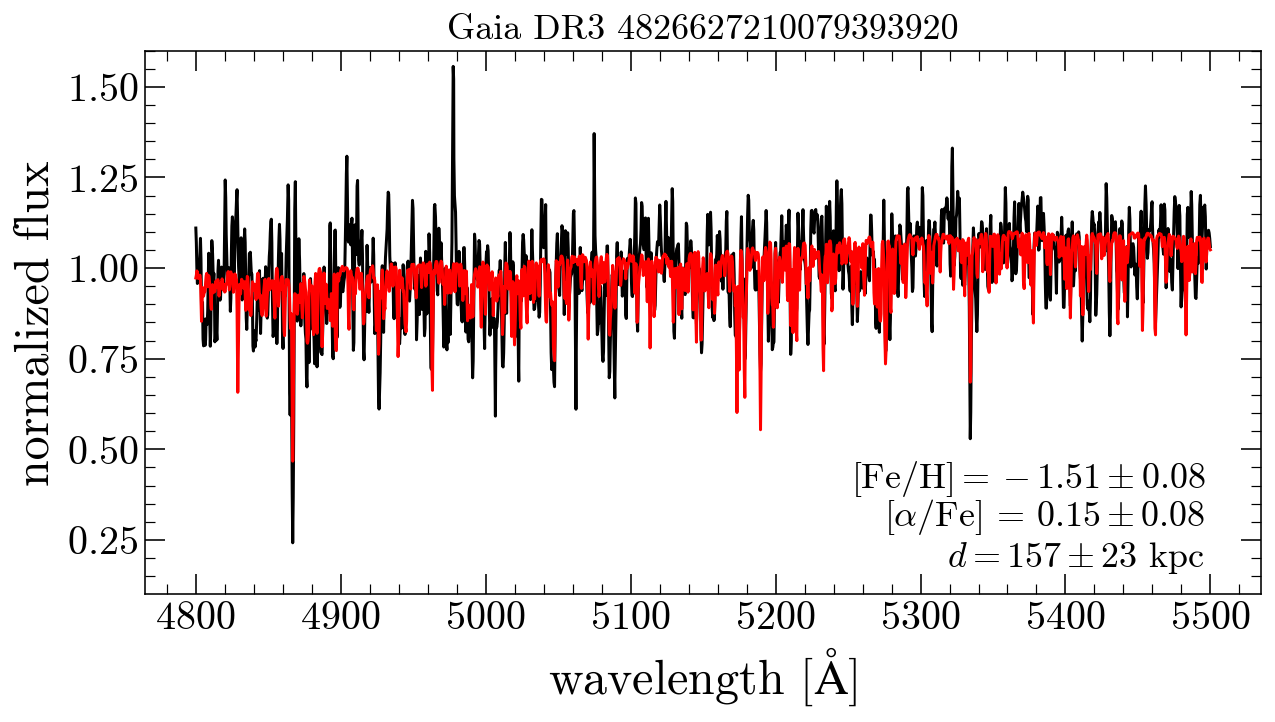

In [146]:
plt.figure(figsize = (10, 5))

plt.plot(spec['wave'], spec['flux_sm'], color = 'k')
plt.plot(bfmod[0], bfflux, color = 'r')

tkw = dict(fontsize = 18, ha = 'right', va = 'top')

plt.text(0.95, 0.25, '$\mathrm{[Fe/H]} = %.2f \pm %.2f$' % (bf['[Fe/H]'], err['[Fe/H]']), transform = plt.gca().transAxes, **tkw)
plt.text(0.95, 0.18, r'[$\alpha$/Fe] = $%.2f \pm %.2f$' % (bf['[a/Fe]'], err['[a/Fe]']), transform = plt.gca().transAxes, **tkw)
plt.text(0.95, 0.1, '$d = %i \pm %i$ kpc' % (bf['Dist'] / 1000, err['Dist'] / 1000), transform = plt.gca().transAxes, **tkw)

#plt.xlim(5100, 5250)
plt.ylim(0.1, 1.6)

plt.title('Gaia DR3 %i' % source_id, fontsize = 18);
plt.ylabel('normalized flux')
plt.xlabel(r'wavelength [$\rm{\AA}$]')

In [95]:
night = '2023_02_07'

In [3]:
dataf = '/n/holyscratch01/conroy_lab/vchandra/mage/data/'
nightf = dataf + night + '/'

In [4]:
masterfiles = np.sort(glob.glob(nightf + 'reduced_v0/magellan_mage_A/Masters/*'))

In [5]:
scifiles = np.sort(glob.glob(nightf + 'reduced_v0/magellan_mage_A/Science/spec1d*.fits'))

In [8]:
for file in scifiles:
    
    if 'hip66765' in file:
        f = fits.open(file)
        
        print(f[1].header)
        
        f.close()

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  162 / length of dimension 1                          NAXIS2  =                 2048 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   22 / number of table fields                         VERSPYT = '3.9.13  '           / Python version                                 VERSNPY = '1.23.4  '           / Numpy version                                  VERSSCI = '1.9.3   '           / Scipy version                                  VERSAST = '5.1.1   '           / Astropy version                                VERSSKL = '1.1.3   '           / Scikit-